# Sérsic vs Interpolated source demo

This notebook shows how to take one row from the **`matched`** table that you generated earlier, load the corresponding COSMOS cut‐out and simulate two images with **SLSim**:

* an *analytic* single–Sérsic source
* an *interpolated* source that uses the real COSMOS galaxy stamp

For reproducibility the cell below just grabs the first entry in `matched`, but feel free to replace the selector by any other row.


In [7]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pickle

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, Planck13
from astropy.table import Table
import astropy.units as u

from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.LOS.los_individual import LOSIndividual
from slsim.lens import Lens
from slsim.image_simulation import lens_image, sharp_image, simulate_image
from slsim.Util.cosmo_util import flux_weighted_center
from slsim.Util.param_util import transformmatrix_to_pixelscale


z,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_y,e1,e2,n_sersic,mag_i_abs,MatchedIndex,Distance,COSMOS_IDENT,COSMOS_RA,COSMOS_DEC,COSMOS_MAG,COSMOS_BAND,COSMOS_WEIGHT,COSMOS_GAL_FILENAME,COSMOS_PSF_FILENAME,COSMOS_GAL_HDU,COSMOS_PSF_HDU,COSMOS_PIXEL_SCALE,COSMOS_NOISE_VARIANCE,COSMOS_NOISE_FILENAME,COSMOS_stamp_flux,COSMOS_mag_auto,COSMOS_flux_radius,COSMOS_zphot,COSMOS_sersicfit,COSMOS_bulgefit,COSMOS_viable_sersic,COSMOS_flux,COSMOS_ID,COSMOS_RPETRO,COSMOS_RHALF,COSMOS_CONCPETRO,COSMOS_ASYMMETRY,COSMOS_GINI,COSMOS_M20,COSMOS_Axial Ratio,COSMOS_AUTOCLASS,COSMOS_CLASSWEIGHT,COSMOS_MAG_DIFF,COSMOS_RHALFreal,COSMOS_MAGabs,COSMOS_phi_G
,,,,kpc,,arcsec,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,
float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int32,float64,float64,float64,bytes5,float64,bytes32,bytes36,int32,int32,float64,float64,bytes26,float64,float64,float64,float64,float64[8],float64[16],int32,float64[4],int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64
0.41646112943095204,-18.385056365775664,0.050475851678312714 .. 0.016159963115974618,0.6806386351267348,1.7308100062283125,6170732588.541217,0.3144025620579916,23.97269221660992,23.021021113662172,22.659817365513305,22.438253268258265,22.22694174251464,-1.0,-1.0,-1.0,-17.61612490466321,56114,0.019740168747908505,448957,149.735282,2.180806,23.086999893188477,F814W,0.26228001713752747,real_galaxy_images_23.5_n33.fits,real_galaxy_PSF_images_23.5_n33.fits,195,195,0.029999999329447746,7.802300387993455e-06,acs_I_unrot_sci_20_cf.fits,7.243666358925111,23.087373733520508,26.903839111328125,0.0568000003695488,0.0008163094916132617 .. -1.0960362837937474,0.00012014290231693771 .. -1.0814563062189264,1,12.742063994282606 .. 0.0,467949,22.4780006,139.3580017,-2.2509999,0.301,0.311,-1.0779999,0.636,3,0.82,-0.08979989318847714,4.605278302354953,-13.695137969486908,4.300005592625512
0.36143492051353904,-18.917743902065446,0.17471342939643736 .. 0.1657769787230427,0.2199204326098986,2.3118818881716083,4113504460.098009,0.45841270593223155,22.675878677112713,22.112816927197528,21.96416668056559,21.775675821304546,21.74741489941765,-1.0,-1.0,-1.0,-18.121503965610486,56170,0.02099056284562212,52795,149.841376,1.754284,23.11400032043457,F814W,0.22794000804424286,real_galaxy_images_23.5_n29.fits,real_galaxy_PSF_images_23.5_n29.fits,904,904,0.029999999329447746,7.985720003489405e-06,acs_I_unrot_sci_20_cf.fits,8.8806637595535,23.11374855041504,12.94825267791748,0.1234000027179718,0.00016446258552167646 .. 2.4965811032860086,0.00016785451155501379 .. -0.5200576872526403,1,30.709001346182255 .. 0.0,563026,22.5739994,122.6460037,-1.842,0.454,0.26,-1.0190001,0.457,3,0.64,0.77099987956543,8.153437286396722,-15.185954359003524,2.5575859678395307
0.8582218610836334,-21.40020789785394,0.2783224543048387 .. 0.138325830081655,0.5696813626371827,3.29366507170619,28641341936.525566,0.4287712322353261,23.119950605661607,22.57767510861376,21.794773842243586,21.500278483643918,21.41959598464809,-1.0,-1.0,-1.0,-19.2046207983595,25608,0.010875968871610651,93576,150.060357,2.615719,23.31100082397461,F814W,0.22620001435279846,real_galaxy_images_23.5_n34.fits,real_galaxy_PSF_images_23.5_n34.fits,139,139,0.029999999329447746,9.569040230417158e-06,acs_I_unrot_sci_20_cf.fits,11.759877059288556,23.311307907104492,8.162543296813965,0.4625999927520752,0.022634551012575634 .. 0.8788502720490622,0.017761735010134696 .. -0.11300028799070683,1,11.697994605789342 .. 0.0,92787,16.5219994,72.288002,-2.9430001,0.109,0.379,-1.5650001,0.871,3,0.45,-0.024900423974610675,12.686699967815647,-17.096929428294295,1.98869238367157
0.8923478782191684,-20.564546181977924,0.42121912830136843 .. 0.028744636951328683,0.6800771794209377,3.0057489426390736,44288407308.615486,0.386745417127199,23.642643882473816,23.372582524596314,22.8023715343

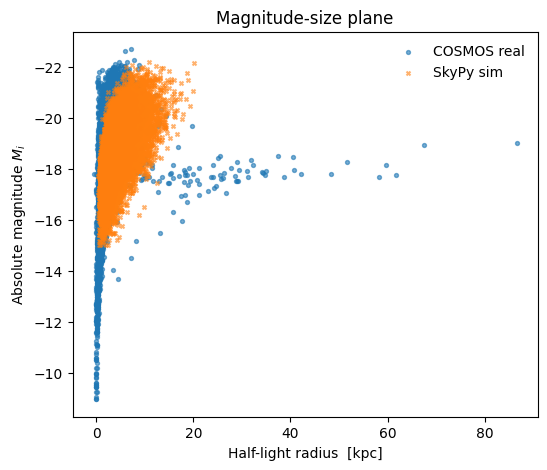

In [ ]:
from slsim.Util.real_to_sim_matching import build_matched_table, plot_mag_size

source_params_dict = {'z_source' : 1.5,
'cosmos_folder' : r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample",
'max_z' : 1.0,
'minimum_size_in_pixels' : 50,
'faintest_apparent_mag' : 23,
'smoothing_sigma' : 0.0,
'random_rotation' : True,
'output_ab_zeropoint' : 25.127,
'center_x' : 0.0,
'center_y' : 0.0,
'min_flux_radius' : 10.0,
'source_exclusion_list' : [79, 309, 1512, 5515, 7138, 7546, 9679, 14180, 14914, 19494, 22095, 28335, 32696, 32778, 33527, 34946, 36344, 38328, 40837, 41255, 44363, 44871, 49652, 51303, 52021, 55803, 1368, 1372, 1626, 5859, 6161, 6986, 7312, 8108, 8405, 9349, 9326, 9349, 9745, 9854, 9948, 10146, 10446, 11209, 12397, 14642, 14909, 15473, 17775, 17904, 20256, 20489, 21597, 21693, 22380, 23054, 23390, 23790, 24110, 24966, 26135, 27222, 27781, 28297, 29550, 30089, 30898, 30920, 31548, 32025, 33699, 35553, 36409, 36268, 36576, 37198, 37969, 38873, 40286, 40286, 40924, 41731, 44045, 45066, 45929, 45929, 46575, 47517, 48137, 49441, 52270, 52730, 52759, 52891, 54924, 54445, 55153, 10584, 22051, 22365, 23951, 42334, 42582, 51492, 32135, 37106, 37593, 38328, 45618, 47829]
}

# 1) Build + match (and get the raw tables back)
matched, sim_tab, real_tab = build_matched_table(
    catalog_paths={
        "cat1":   r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample\real_galaxy_catalog_23.5.fits",
        "cat2":   r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\COSMOS_23.5_Image_catalog\COSMOS_23.5_training_sample\real_galaxy_catalog_23.5_fits.fits",
        "morpho": r"C:\Users\rahul\OneDrive\Documents\GitHub\Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data\Datasets\Morphology\cosmos_morphology_cassata_1.1.tbl",
    },
    cosmo_kwargs=dict(H0=70, Om0=0.3),
    sky_area_deg2=1.5,
    source_params=source_params_dict,
    build_sim_kwargs=dict(kwargs_cut=dict(band="i", band_max=23, z_min=0.1, z_max=1.5)),
    nn_tolerance=None,
    cache=True,
    return_tables=True,
)

# 2) Quick visual comparison
plot_mag_size(real_tab, sim_tab, save="mag_size_scatter.png")
matched

In [54]:
real_images_dir = r"C:/Users/rahul/OneDrive/Documents/GitHub/Simulating_and_Predicting_Nancy_G_Roman_Telescope_Data/Datasets/COSMOS_23.5_Image_catalog/COSMOS_23.5_training_sample"
# Sort the table in descending order of 'mag_i'
matched.sort('mag_i', reverse=True)

# Select the top row
row = matched[8]

# `row` is one record of your `matched` astropy table
fname = row['COSMOS_GAL_FILENAME']             # e.g. 'gal_123456.fits'
hdu   = row['COSMOS_GAL_HDU']           # usually 0 or 1

img_path = os.path.join(real_images_dir, fname)

with fits.open(img_path) as hdul:
    real_img = hdul[hdu].data.astype(float)    # 2-D numpy array (counts s⁻¹)

print(f"loaded {fname} (HDU {hdu}) — shape {real_img.shape}")

loaded real_galaxy_images_23.5_n39.fits (HDU 57) — shape (101, 102)


In [55]:
#-------------------------------------------------
# 3) build a *minimal* deflector ("red_one" template)
#    Here we follow the same zero‑mass placeholder adopted earlier
#-------------------------------------------------
deflector_dict = dict(
    z          = 0.08,    # same redshift as the source
    theta_E    = 0.05,
    e1_light   = 0.0, e2_light = 0.0,
    e1_mass    = 0.0, e2_mass  = 0.0,
    gamma_pl   = 2.0,
    angular_size = 0.05,
    n_sersic     = 1.0,
    mag_g=99., mag_r=99., mag_i=99., mag_z=99., mag_y=99.,
)


red_one_path = r"C:\Users\rahul\OneDrive\Documents\GitHub\slsim-COSMOS-source-class\tests\TestData\red_one_modified.fits"

# Load the red_one_modified data
red_one = Table.read(red_one_path, format="fits")
red_one['z'] = 0.08  # Set the redshift to 0.08

# Create a Deflector object using the red_one data
deflector = Deflector(deflector_type="EPL", deflector_dict=red_one)

# Example usage of the deflector object
print("Deflector light ellipticity:", deflector.light_ellipticity)
print("Deflector mass ellipticity:", deflector.mass_ellipticity)
print("Deflector redshift:", deflector.redshift)
print("Deflector Stellar Mass:", deflector.stellar_mass)

Deflector light ellipticity: (-0.05661955320450283, 0.08738390223219591)
Deflector mass ellipticity: (-0.084347, 0.097106)
Deflector redshift: 0.08
Deflector Stellar Mass:    stellar_mass  
-----------------
69416042146.55305


In [56]:
#-------------------------------------------------
# 4) build both source models
#-------------------------------------------------
# (a) analytic single‑Sérsic
z = row['z']
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

source_x, source_y = 0, 0

angular_size = row['angular_size']
sersic_dict = dict(
    z            = z,  # same redshift as the deflector
    mag_i        = row['mag_i'],
    n_sersic     = 1,
    angular_size = angular_size,  # arcsec
    e1           = row['e1'],
    e2           = row['e2'],
    phi_G        = row['COSMOS_phi_G'],
    center_x    = source_x,
    center_y    = source_y,  # arcsec
)

source_sersic = Source(
    source_dict=sersic_dict,
    source_type="extended",
    extendedsource_type="single_sersic",
    cosmo=cosmo,
)

# (b) interpolated source built from the real image
interp_dict = dict(
    z             = row['z'],
    z_data        = row['COSMOS_zphot'],          # image taken at same redshift
    mag_i         = row['mag_i'],
    image         = real_img,          # 2‑D numpy array
    phi_G         = 0, #row['COSMOS_phi_G'],
    pixel_width_data = row['COSMOS_PIXEL_SCALE'],       # arcsec / pixel
    center_x = source_x, #flux_weighted_center(real_img)[0],
    center_y = source_y#flux_weighted_center(real_img)[1],
)

source_interp = Source(
    source_dict=interp_dict,
    source_type="extended",
    extendedsource_type="interpolated",
    cosmo=cosmo,
    center_x=source_x,
    center_y=source_y,
)


In [57]:
#-------------------------------------------------
# 5) Lens class wrappers
#-------------------------------------------------
los = LOSIndividual(kappa=0., gamma=[0., 0.])

lens_sersic = Lens(source_class=source_sersic,
                   deflector_class=deflector,
                   los_class=los,
                   cosmo=cosmo)

lens_interp = Lens(source_class=source_interp,
                   deflector_class=deflector,
                   los_class=los,
                   cosmo=cosmo)


In [ ]:
#-------------------------------------------------
# 6) run the two simulations (no PSF, no noise)
#-------------------------------------------------

# a 1×1 kernel leaves the image unchanged after convolution
psf_kernel = np.array([[1.0]], dtype=float)
pixscale = row['COSMOS_PIXEL_SCALE']
psf_kernel = np.ones((1, 1))
mag_zero_point = 25.127


#num_pix = real_img.shape[0]
num_pix = 200
transform_pix2angle = np.array([[pixscale,0],[0,pixscale]])
print(transform_pix2angle)

sim_sersic_si = simulate_image(lens_class=lens_sersic,
                            band="i",
                            num_pix=num_pix,
                            add_noise=True,
                            observatory="LSST",
)

sim_interp_si = simulate_image(lens_class=lens_interp,
                            band="i",
                            num_pix=num_pix,
                            add_noise=True,
                            observatory="LSST",
)

sim_sersic_li = lens_image(
    lens_class   = lens_sersic,
    band         = "i",
    mag_zero_point = mag_zero_point,
    num_pix      = num_pix,
    psf_kernel   = psf_kernel,
    transform_pix2angle = transform_pix2angle,
    with_source  = True,
    with_deflector = False,
)

sim_interp_li = lens_image(
    lens_class   = lens_interp,
    band         = "i",
    mag_zero_point = mag_zero_point,
    num_pix      = num_pix,
    psf_kernel   = psf_kernel,
    transform_pix2angle = transform_pix2angle,
    with_source  = True,
    with_deflector = False,
)

sim_sersic_sharp = sharp_image(
    lens_class   = lens_sersic,
    band         = "i",
    mag_zero_point = mag_zero_point,
    num_pix      = num_pix,
    delta_pix = 0.04,
    with_source  = True,
    with_deflector = False,
    add_noise=True,
)

sim_interp_sharp = sharp_image(
    lens_class   = lens_interp,
    band         = "i",
    mag_zero_point = mag_zero_point,
    num_pix      = num_pix,
    delta_pix = 0.04,
    with_source  = True,
    with_deflector = False,
)


[[0.03 0.  ]
 [0.   0.03]]


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lenstronomy\LensModel\lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


[{'R_sersic': <Column name='angular_size' dtype='float64' unit='rad' length=1>
7.613175197518637e-07, 'n_sersic': 1.0, 'e1': 0.05661955320450283, 'e2': 0.08738390223219591, 'center_x': -0.07684854623686788, 'center_y': 0.08899193029395946, 'amp': <Column name='mag_i' dtype='float64' length=1>
625237333995.5427}] [{'R_sersic': 1.2652838811904918, 'n_sersic': 1.0, 'e1': 1.0, 'e2': -1.0, 'center_x': 0, 'center_y': 0, 'amp': 8.3187415220531}] None test
[{'R_sersic': <Column name='angular_size' dtype='float64' unit='rad' length=1>
7.613175197518637e-07, 'n_sersic': 1.0, 'e1': 0.05661955320450283, 'e2': 0.08738390223219591, 'center_x': -0.07684854623686788, 'center_y': 0.08899193029395946, 'amp': <Column name='mag_i' dtype='float64' length=1>
625237333995.5427}] [{'image': array([[-1.20022357e-03,  1.35756982e-03,  4.83658165e-03, ...,
         8.49282928e-03, -1.11207506e-03, -3.83941573e-04],
       [ 1.12739357e-03, -1.00492593e-03,  2.95681087e-03, ...,
         1.08086853e-03,  1.731581

TypeError: sharp_image() got an unexpected keyword argument 'add_noise'

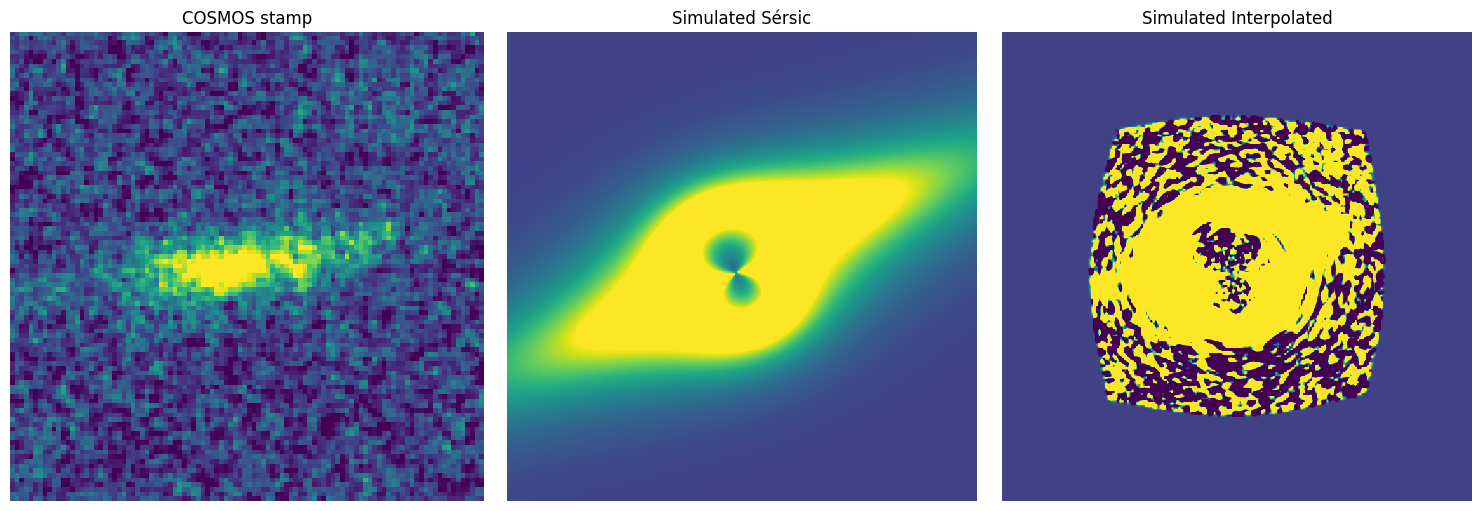

In [59]:
#-------------------------------------------------
# 7) visual comparison
#-------------------------------------------------
vmin, vmax = np.percentile(real_img, [5, 99])

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, img, title in zip(axes,
                          [real_img, sim_sersic_li, sim_interp_li],
                          ['COSMOS stamp', 'Simulated Sérsic', 'Simulated Interpolated']):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


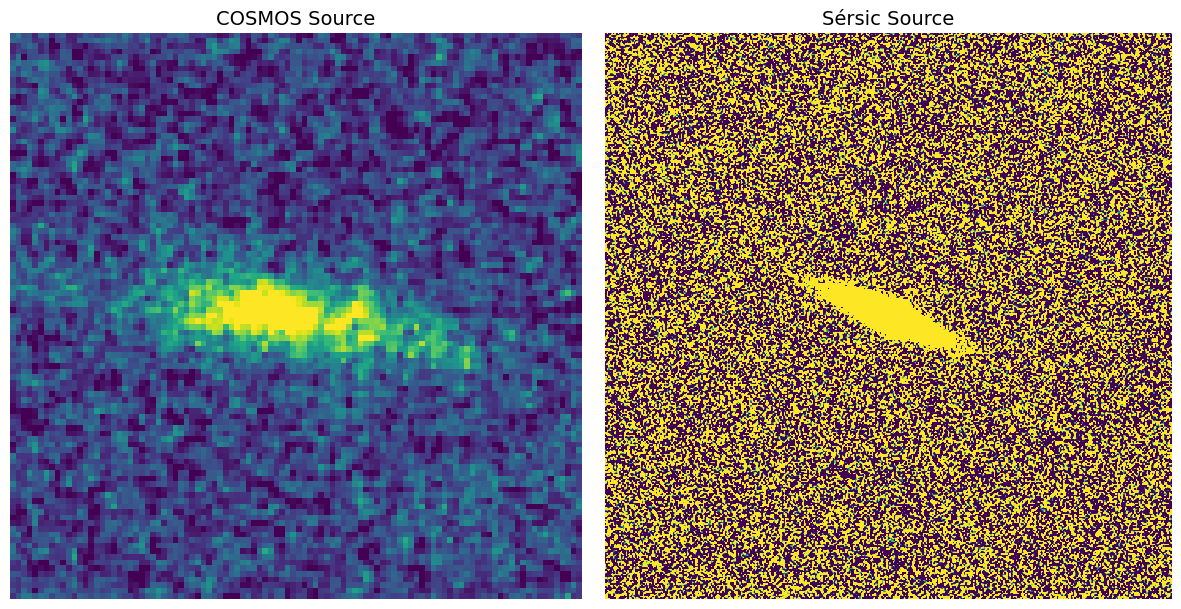

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Define the intensity range for visualization
vmin, vmax = np.percentile(real_img, [5, 99])

# Plot the COSMOS source and Sérsic source side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# COSMOS source
axes[0].imshow(real_img, vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
axes[0].set_title('COSMOS Source', fontsize=14)
axes[0].axis('off')

# Sérsic source
axes[1].imshow(sim_sersic, vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
axes[1].set_title('Sérsic Source', fontsize=14)
axes[1].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

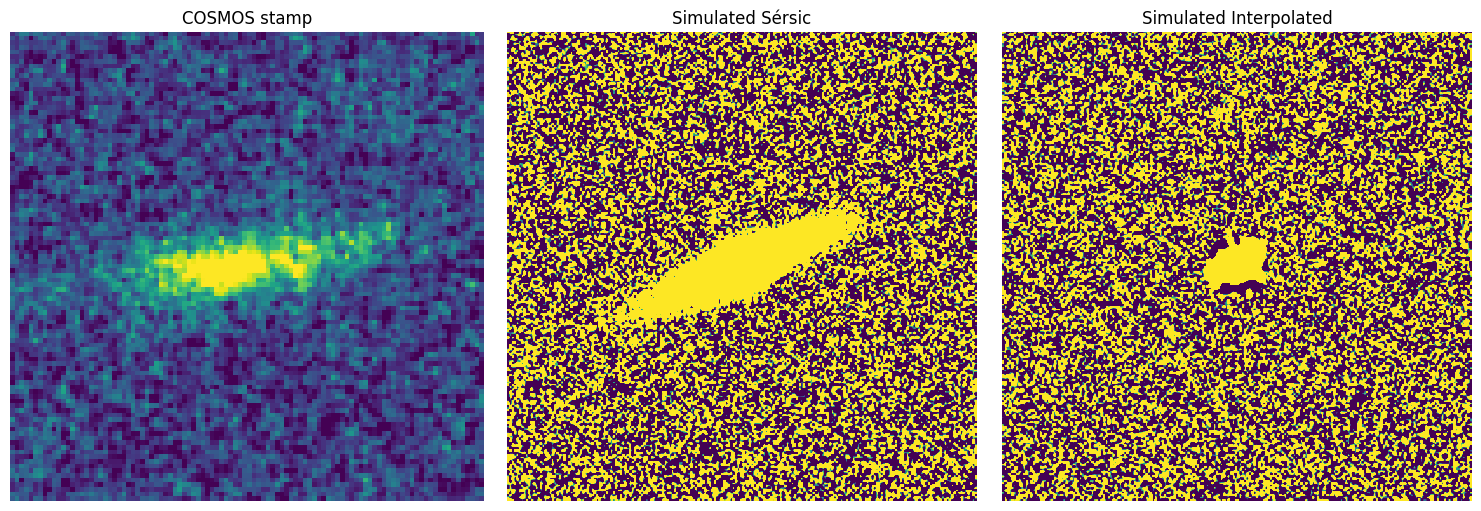

In [ ]:
#-------------------------------------------------
# 7) visual comparison
#-------------------------------------------------
vmin, vmax = np.percentile(real_img, [5, 99])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
for ax, img, title in zip(axes,
                          [sim_sersic_si, sim_interp_si],
                          ['COSMOS stamp', 'Simulated Sérsic', 'Simulated Interpolated']):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


C:\Users\rahul\AppData\Local\Temp\ipykernel_61876\1917999885.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


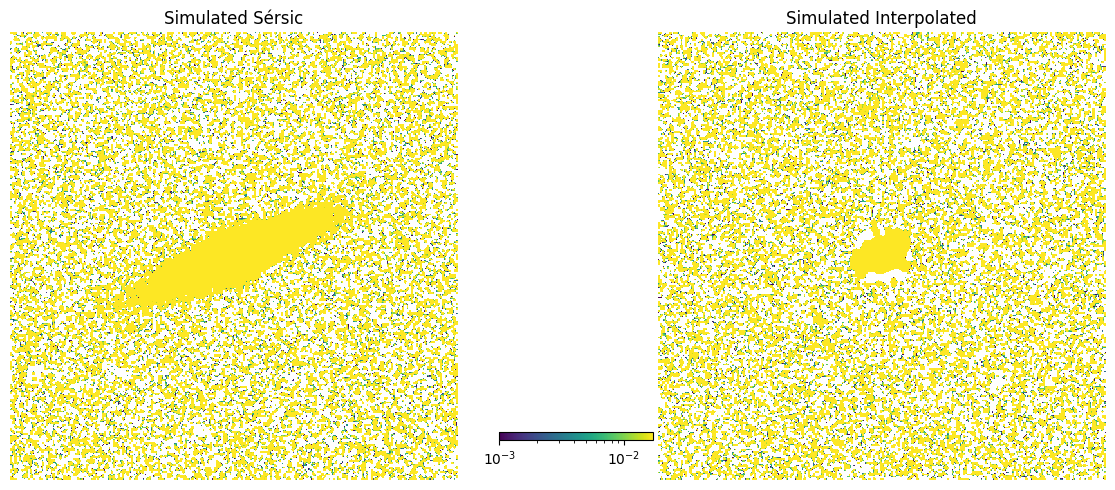

In [70]:
#-------------------------------------------------
# 7) visual comparison with log color scale
#-------------------------------------------------
from matplotlib.colors import LogNorm


vmin, vmax = np.percentile(real_img, [5, 99])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, img, title in zip(axes,
                          [sim_sersic_si, sim_interp_si],
                          ['Simulated Sérsic', 'Simulated Interpolated']):
    # Use a logarithmic color scale
    im = ax.imshow(img, norm=LogNorm(vmin=max(vmin, 1e-3), vmax=vmax), cmap='viridis')
    ax.set_title(title)
    ax.axis('off')

# Add a colorbar
fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout()
plt.show()

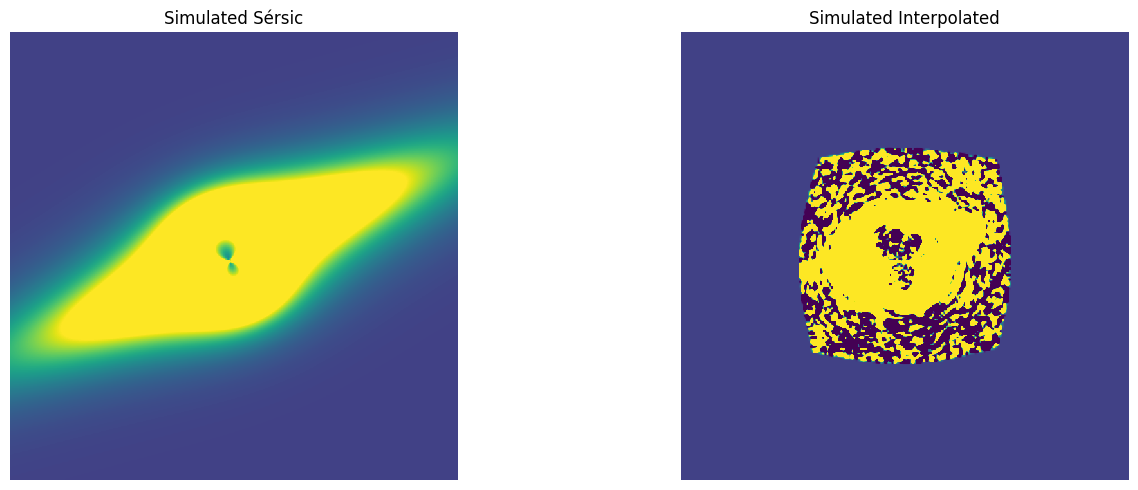

In [69]:
#-------------------------------------------------
# 7) visual comparison
#-------------------------------------------------
vmin, vmax = np.percentile(real_img, [5, 99])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
for ax, img, title in zip(axes,
                          [sim_sersic_sharp, sim_interp_sharp],
                          ['Simulated Sérsic', 'Simulated Interpolated']):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [185]:
# Compute total flux for the Sérsic source
total_flux_sersic = sim_sersic.sum()

# Compute total flux for the interpolated source
total_flux_interp = sim_interp.sum()

# Print the results
print(f"Total flux (Sérsic source): {total_flux_sersic}")
print(f"Total flux (Interpolated source): {total_flux_interp}")

# Check if the total fluxes are approximately equal
if np.isclose(total_flux_sersic, total_flux_interp, rtol=1e-3):
    print("The total fluxes are approximately the same.")
else:
    print("The total fluxes are different.")

Total flux (Sérsic source): 7679479.60975271
Total flux (Interpolated source): 7679749.915645697
The total fluxes are approximately the same.


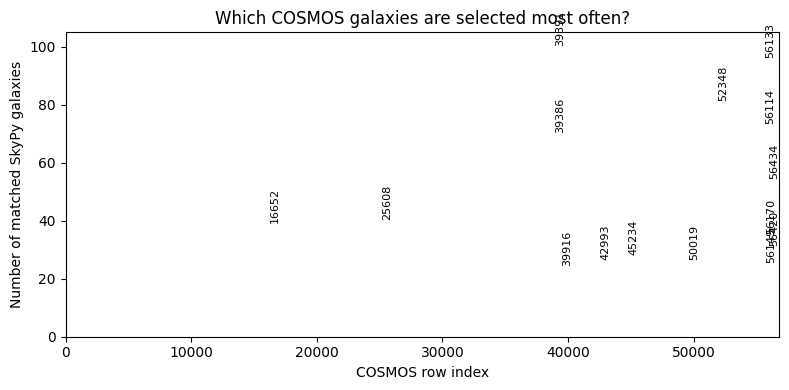

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) how many times each COSMOS galaxy is picked ──────────────────────────
idx     = np.asarray(matched['MatchedIndex'])      # the row numbers in COSMOS
counts  = np.bincount(idx)                        # length = max(idx)+1
x_bins  = np.arange(counts.size)                  # 0 … N-1

# ── 2) plot ─────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x_bins, counts, color='tab:purple', alpha=0.75)
ax.set_xlabel("COSMOS row index")
ax.set_ylabel("Number of matched SkyPy galaxies")
ax.set_title("Which COSMOS galaxies are selected most often?")
ax.set_xlim(-0.5, counts.size - 0.5)

# ── 3) (optional) annotate the 15 most-matched ones ─────────────────────────
top = counts.argsort()[::-1][:15]                 # 15 largest bars
for i in top:
    if counts[i] == 0:
        break
    ax.text(i, counts[i] + 0.3, str(i), ha='center',
            va='bottom', rotation=90, fontsize=8)

plt.tight_layout()
plt.show()
